In [2]:
from scipy.stats import bernoulli, norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import zipline as zp
from zipline import TradingAlgorithm
from zipline.api import order_target, record, symbol, history, add_history 

import pytz
from datetime import datetime

import random
%matplotlib inline

/Users/sy/Dropbox/FinEng/Jupyter/jup1/lib/python2.7/site-packages/pandas/io/data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


### Time Series Models: mostly ARMA

#### White Noise

We simulate white noise:

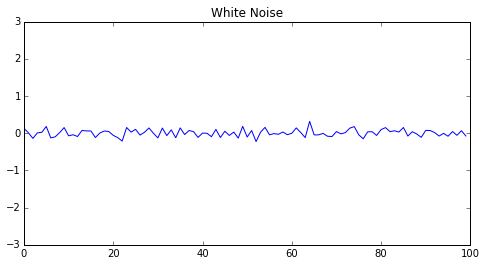

In [11]:
white_noise = pd.Series(np.zeros(100))
mu = 0.0
sig = 0.1

for i in range(len(white_noise)):
    white_noise[i] = pd.Series(random.sample(np.random.normal(mu,sig,100), 1))
    
plt.figure(num=None, figsize=(8,4))
plt.plot(white_noise)
plt.ylim([-3.0,3.0])
plt.title("White Noise")

In financial time series analysis, white noise the best we can have: it is stationary and i.i.d. so ready for mean-reversion.  Moreover we can provide all metrics related to estimation error and risk. Of course, no raw financial data is vert unlikely to be white noise.

In signal processing point of view, white noise is often described as "noise".  If we Fourier transform ideal white noise, uniformly distributed across all frequency spectrum.  So white noise does not contain any information.

#### Random Walk

Consider time series $\{ x_t \}$. We simulate random walk by adding Gaussian "unknowns" on each step. 
$$x_t = x_{t-1} + \epsilon_t $$ 
$\epsilon$ part is best described as unknowns here, well known example is Brownian motion of air molecule in a room.

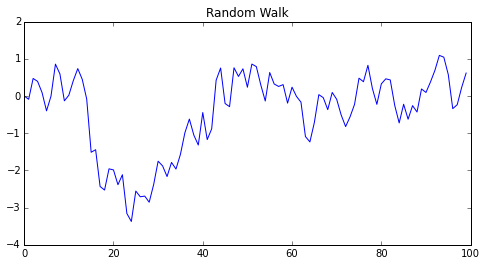

In [15]:
#epsilons = pd.Series(np.random.normal(0,0.01,100)) # make ts pandas series format then plot

r_walks = pd.Series(np.zeros(100))
phi = 1.0

for i in range(1, len(r_walks)):
    r_walks[i] = phi*r_walks[i-1]+random.sample(np.random.normal(0,0.5,100), 1)
    
plt.figure(num=None, figsize=(8,4))
plt.plot(r_walks)
#plt.ylim([-3.0,3.0])
plt.title("Random Walk")

In each time step, $\epsilon_t$ is added to previous position. Each $\epsilon_t$ follows Distribution Identical with previous $\epsilon_{t-1}, \epsilon_{t-2}, \dots$. However, it is Independent from the previous steps. $x_{t-1}$ represents 'history' part.  Yet, this memory is too perfect, we need attenuation:we want more relaistic autoregressive behaviour.

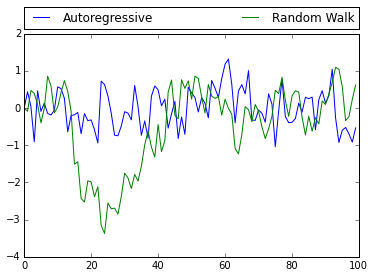

In [19]:
xs = pd.Series(np.zeros(100))
phi = 0.3

for i in range(1, len(xs)):
    xs[i] = phi*xs[i-1]+random.sample(np.random.normal(0,0.5,100), 1)


plt.plot(xs, label="Autoregressive")
plt.plot(r_walks, label="Random Walk")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

Our memory traces several days, say upto n, so we add more autoregressive terms:

$$x_t = \phi_1 x_{t-1} + \phi_2 x_{t-2} + \phi_3 x_{t-3} + \dots  + \phi_n x_{t-n} + \epsilon_t $$ 

We call this model AR(n)

In signal processing, AR time series can be viewed as Finite Impulse Response filter. Common technical metric such as rolling mean can be considered as a lowpass filter that "smooths" out a signal by removing high frequency 'fluctuations.'  

(-5, 5)

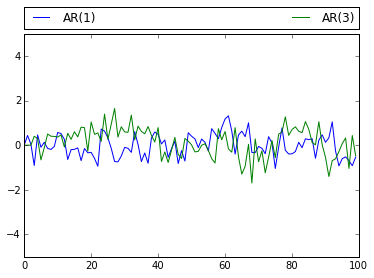

In [30]:
x_ar = pd.Series(np.zeros(100))
phi1 = 0.3
phi2 = 0.25
phi3 = 0.19

for i in range(3, len(x_ar)):
    x_ar[i] = phi1*x_ar[i-1] + phi2*x_ar[i-2] + phi3*x_ar[i-3] + random.sample(np.random.normal(0,0.5,100), 1)


plt.plot(xs, label="AR(1)")
plt.plot(x_ar, label="AR(3)")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([-5,5])

#### AutoRegressiv Moving Average (ARMA) : how about the memory of shocks

So far, we call $\epsilon_t$ part as 'unknowns, shocks, errors, news' depending on contexts.  When we take 'news' interpretation, it is reasonable our memory is infulenced by news from the previous steps, $\epsilon_{t-1}, \epsilon_{t-2}, \dots $

Now we add these influences of news part:
$$x_t = \sum_{i=1}^m \phi_i x_{t-i} + \sum_{j=1}^n  \varphi_j \epsilon_{t-j} + \epsilon_t $$ 
This is AutoRegressive Moving Average, ARMA(m,n) model.

(-5, 5)

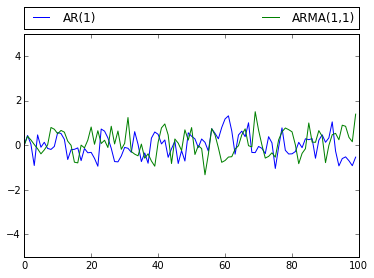

In [31]:
x_arma = pd.Series(np.zeros(100))
ep_t = pd.Series(np.zeros(100))
phi1 = 0.3
varphi1 = 0.1

ep_t[0] = random.sample(np.random.normal(0,0.5,100), 1)[0]

for i in range(1, len(x_arma)):
    ep_t[i] = random.sample(np.random.normal(0,0.5,100), 1)[0]
    x_arma[i] = phi1*x_arma[i-1] + varphi1*ep_t[i-1] + ep_t[i]


plt.plot(xs, label="AR(1)")
plt.plot(x_arma, label="ARMA(1,1)")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([-5,5])

#### ARCH: Taking care of Volatility

We finally view $\epsilon$ part as 'volatility'. ARMA model still treats volatility independent from history.  THis is not true for many financial data.  So we apply ARMA style modeling to volatility, variance to be specific. That's the gist of ARCH model.  

#### Practical Discussion

- We estimate $\phi_i, \varphi_j, m, n$ in ARMA modelling using statistical methods.  Various metrics can be given for goodness of fit and so on.  Choosing large $m, n$ and choosing complex model for volatility part is not practical.  A good compromise seems to be GARCH(1,1)

- Understanding natures of financial data helps great deal choosing a good model.  We want to record our experiences: what type of finanical data are appropriate for which time series model. 

- We want to take into account seasonality and market trend.    

- We emphasize ARMA/ARCH is just another model: a way to think about and help us understand data.  We can and should pursue alternative approach. For example, techniques based on signal processing, such as lowpass filter, FFT, Kalman filter, can be appropriate some cases.

- However, basic time series modelling seems the most natural way we can take for preliminary investigation of time dependent data.

- Time series analysis can be applied to not only modeling but also risk management.

- The main drawback of time series modelling, as opposed to similar ideas in technicals, is that its application requires much more pre-knowledge. 